In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.utils.np_utils import to_categorical
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, utils
!pip install numpy==1.19.5

In [2]:
df = pd.read_csv('../../data/anonymized_bsc_dataPVZ.csv', low_memory=False)

In [3]:
df.head()

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
0,15/SP,DA 101 A,Basic Ballet,F,0.5,3.0,W,3.0,3.667,Melissa Turnage,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
1,15/SP,HI 155 A-ES,Reforming America,F,1.0,NaN,A-,3.0,3.667,Victoria Ott,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
2,15/SP,PL 200 A-CI,Ethical Choice,F,1.0,NaN,B+,3.0,3.667,William Myers,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
3,15/SP,IDS 200 A-CI,Intro to Human Rights (GP),F,1.0,NaN,A,3.0,3.667,Sandra Sprayberry,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
4,15/WI,GEN E299 49,Exploration Project,F,1.0,1.0,S,1.0,0.000,Vincent Gawronski,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology


# Preprocessing

In [4]:
#changing nomenclature for term so that we can sort in chronological order by that column
df['Sttr Term'] = df['Sttr Term'].replace({'WI':'A','SP':'B', 'SU':'C', 'FA':'D'}, regex=True)
#dropping completely null rows
df.drop(df.index[51518:51537], inplace=True)
#isolating students who would have been able to graduate in the timeframe of our given data
df = df.loc[(df['Cohort'] == '14/FA') | (df['Cohort'] == '15/FA') | (df['Cohort'] == '16/FA')
              | (df['Cohort'] == '17/FA')]
df = df.dropna(subset=['Sttr Term'])
df['alt_id'] = df['alt_id'].astype(int)
#encoding our target
mapping = {'N': 0, 'Y': 1}
df['Graduated'] = df['Graduated'].map(mapping)
data = df.sort_values(['Sttr Term'], ascending=True)
data.head()

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
6784,14/D,EH 208 B,Intermediate Writing,F,1.00,NaN,F,1.00,1.110,Sandra Sprayberry,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Urban Environmental Studies
7369,14/D,BI 115 A-SM,Organismal Biology,F,1.00,3.0,F,1.00,0.557,Andrew Gannon,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
7370,14/D,PY 101 F,Introduction to Psychology,F,1.00,NaN,C-,1.00,0.557,Gabrielle Smith,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
7371,14/D,EH 102 C,Sem Critical Thinking Writing,F,1.00,NaN,F,1.00,0.557,Steven Carter,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1114,14/D,MS 120 D,Voice,F,0.25,NaN,A,3.25,3.591,Erin Ludwick,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Biology


# EDA

In [5]:
#investigating how many classes students are taking to find outliers
df.alt_id.value_counts(ascending=False)

1139    64
1469    62
2046    62
1002    62
2328    60
        ..
2030     3
2516     3
1732     3
1191     3
1857     3
Name: alt_id, Length: 1455, dtype: int64

In [6]:
#Checking for Course Title Duplicates
df['course_title'].nunique()

952

# Modeling

## Course Sequential Model

In [7]:
#target = []
#student_ids = df.alt_id.unique()
#for s_id in student_ids:
 #   grad = df[df['alt_id'] == s_id].iloc[0].Graduated
  #  target.append(grad)

In [8]:
#Baseline Course Sequence
def course_modeling(df, N, E):
    target = []
    course_sequences = []
    student_ids = df.alt_id.unique()
    for s_id in student_ids:
        grad = df[df['alt_id'] == s_id].iloc[0].Graduated
        target.append(grad)
    for s_id in student_ids:
        frame = df[df['alt_id'] == s_id]
        course_ids = ' '.join(frame.course_title.str.replace(' ', '').to_list())
        course_sequences.append(course_ids)
        
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(course_sequences)
    #Tozenizing course sequences to prepare for model
    encoded_sequences = tokenizer.texts_to_sequences(course_sequences)
    #Accounting for students with many more courses
    padded_course_sequences = pad_sequences(encoded_sequences, maxlen=N, dtype='int32', padding='post',
    truncating='post', value=0.0)
    padded_reshaped_courses = padded_course_sequences.reshape(1455, N, 1)

    model = Sequential()
    input_layer = Input(shape=(N, 1))
    sequential_1 = LSTM(64, activation='relu')
    output_layer = Dense(1, activation='sigmoid')

    model.add(input_layer)
    model.add(sequential_1)
    model.add(output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    model.fit(padded_reshaped_courses, np.array(target), epochs=E, validation_split = .2)
    
     #plot
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(model.history.epoch, model.history.history['loss'], label='Train')
    ax1.plot(model.history.epoch, model.history.history['val_loss'], label='Validation')
    
    ax1.legend()
    
    ax2.plot(model.history.epoch, model.history.history['accuracy'], label='Train')
    ax2.plot(model.history.epoch, model.history.history['val_accuracy'], label='Validation')
    
    ax2.legend()

### Baseline - Full Course Sequence

Epoch 1/50
37/37 [==============================] - 1s 23ms/step - loss: 24.6953 - accuracy: 0.5043 - val_loss: 42.9132 - val_accuracy: 0.4742
Epoch 2/50
37/37 [==============================] - 0s 13ms/step - loss: 27.5073 - accuracy: 0.5052 - val_loss: 30.7596 - val_accuracy: 0.4742
Epoch 3/50
37/37 [==============================] - 0s 13ms/step - loss: 26.2238 - accuracy: 0.5163 - val_loss: 20.9979 - val_accuracy: 0.5052
Epoch 4/50
37/37 [==============================] - 0s 12ms/step - loss: 13.8883 - accuracy: 0.6125 - val_loss: 20.2256 - val_accuracy: 0.6151
Epoch 5/50
37/37 [==============================] - 0s 13ms/step - loss: 10.5585 - accuracy: 0.6770 - val_loss: 9.2205 - val_accuracy: 0.6976
Epoch 6/50
37/37 [==============================] - 1s 14ms/step - loss: 8.6168 - accuracy: 0.7629 - val_loss: 19.5149 - val_accuracy: 0.6907
Epoch 7/50
37/37 [==============================] - 0s 13ms/step - loss: 11.9181 - accuracy: 0.7637 - val_loss: 17.7765 - val_accuracy: 0.7491
E

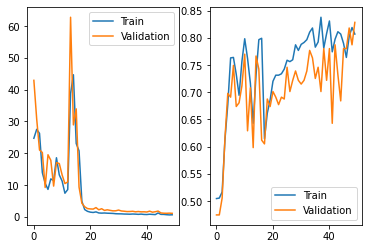

In [9]:
#Full Term
fullcoursemodel = course_modeling(data,45,50)

### First Semester Freshman Year

Epoch 1/20
37/37 [==============================] - 0s 7ms/step - loss: 3.9864 - accuracy: 0.5258 - val_loss: 1.2124 - val_accuracy: 0.6014
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.9357 - accuracy: 0.5765 - val_loss: 0.8904 - val_accuracy: 0.5498
Epoch 3/20
37/37 [==============================] - 0s 2ms/step - loss: 0.7750 - accuracy: 0.6280 - val_loss: 0.8783 - val_accuracy: 0.4674
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.6383 - val_loss: 0.8123 - val_accuracy: 0.5189
Epoch 5/20
37/37 [==============================] - 0s 2ms/step - loss: 0.6664 - accuracy: 0.6615 - val_loss: 0.8306 - val_accuracy: 0.5223
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6538 - val_loss: 0.7900 - val_accuracy: 0.5808
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6658 - val_loss: 0.7601 - val_accuracy: 0.5498
Epoch 8/20
37/37 [==

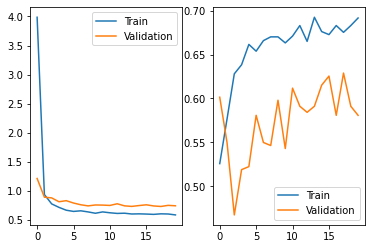

In [10]:
#First Semester Freshman
course_modeling(data,4,20)

### After Sophomore Year

Epoch 1/15
37/37 [==============================] - 0s 11ms/step - loss: 1.7334 - accuracy: 0.7010 - val_loss: 1.5752 - val_accuracy: 0.6701
Epoch 2/15
37/37 [==============================] - 0s 5ms/step - loss: 0.8208 - accuracy: 0.7904 - val_loss: 1.0791 - val_accuracy: 0.7526
Epoch 3/15
37/37 [==============================] - 0s 5ms/step - loss: 0.6110 - accuracy: 0.8239 - val_loss: 1.0035 - val_accuracy: 0.7595
Epoch 4/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4963 - accuracy: 0.8282 - val_loss: 0.7535 - val_accuracy: 0.7560
Epoch 5/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4855 - accuracy: 0.8308 - val_loss: 0.8711 - val_accuracy: 0.7423
Epoch 6/15
37/37 [==============================] - 0s 6ms/step - loss: 0.4585 - accuracy: 0.8514 - val_loss: 0.7530 - val_accuracy: 0.7457
Epoch 7/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4344 - accuracy: 0.8479 - val_loss: 0.6899 - val_accuracy: 0.7698
Epoch 8/15
37/37 [=

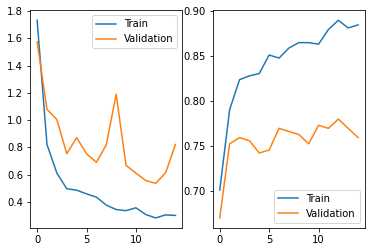

In [11]:
#Sophomore
course_modeling(data,16,15)

## Baseline Sequential Grades Model

In [12]:
#baseline grades
def grade_modeling(df,N,E):
    student_ids = df.alt_id.unique()
    target = []
    for s_id in student_ids:
        grad = df[df['alt_id'] == s_id].iloc[0].Graduated
        target.append(grad)
    grade_sequences = []
    for s_id in student_ids:
        frame = df[df['alt_id'] == s_id]
        grades = ' '.join(frame['Sttr Stu Final Grades'].to_list())
        grade_sequences.append(grades)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(grade_sequences)
    encoded_sequences = tokenizer.texts_to_sequences(grade_sequences)
    padded_grade_sequences = pad_sequences(
    encoded_sequences, maxlen=N, dtype='int32', padding='post',
    truncating='post', value=0.0)
    padded_reshaped_grades = padded_grade_sequences.reshape(1455, N, 1)

    model = Sequential()
    input_layer = Input(shape=(N, 1))
    sequential_1 = LSTM(64, activation='relu')
    output_layer = Dense(1, activation='sigmoid')

    model.add(input_layer)
    model.add(sequential_1)
    model.add(output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    model.fit(padded_reshaped_grades, np.array(target), epochs=E, validation_split = .2)
    
    accuracy = model.history.history['accuracy']
    print(round(accuracy[-1],2))
    
     #plot
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(model.history.epoch, model.history.history['loss'], label='Train')
    ax1.plot(model.history.epoch, model.history.history['val_loss'], label='Validation')
    
    ax1.legend()
    
    ax2.plot(model.history.epoch, model.history.history['accuracy'], label='Train')
    ax2.plot(model.history.epoch, model.history.history['val_accuracy'], label='Validation')
    
    ax2.legend()
    
    #loss = model.history.history['loss']
   # print(round(loss[-1],2))

#pd.DataFrame(feature_encoder.transform(np.array(padded_grade_sequences[0]).reshape(-1,1)).todense())
#np.array(padded_grade_sequences[0]).reshape(-1,1)

### Baseline -- Full Grade Sequence

Epoch 1/10
37/37 [==============================] - 1s 17ms/step - loss: 0.6756 - accuracy: 0.6589 - val_loss: 0.6545 - val_accuracy: 0.5601
Epoch 2/10
37/37 [==============================] - 0s 12ms/step - loss: 0.5872 - accuracy: 0.7603 - val_loss: 0.6117 - val_accuracy: 0.8282
Epoch 3/10
37/37 [==============================] - 0s 12ms/step - loss: 0.5837 - accuracy: 0.9167 - val_loss: 0.4420 - val_accuracy: 0.8110
Epoch 4/10
37/37 [==============================] - 0s 12ms/step - loss: 0.4071 - accuracy: 0.9399 - val_loss: 0.3978 - val_accuracy: 0.8935
Epoch 5/10
37/37 [==============================] - 0s 11ms/step - loss: 0.3653 - accuracy: 0.9450 - val_loss: 0.4643 - val_accuracy: 0.7938
Epoch 6/10
37/37 [==============================] - 0s 11ms/step - loss: 0.3336 - accuracy: 0.9227 - val_loss: 0.2904 - val_accuracy: 0.9210
Epoch 7/10
37/37 [==============================] - 0s 11ms/step - loss: 0.3344 - accuracy: 0.9261 - val_loss: 0.3720 - val_accuracy: 0.8763
Epoch 8/10
37

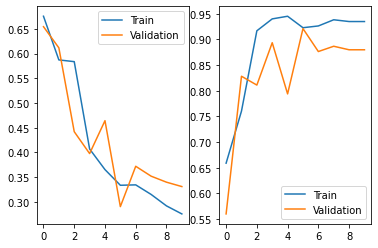

In [13]:
#Full Course - 45 classes
grade_modeling(data,45,10)

### First Semester Freshman Year Grades

Epoch 1/15
37/37 [==============================] - 0s 8ms/step - loss: 0.6769 - accuracy: 0.6194 - val_loss: 0.7100 - val_accuracy: 0.5601
Epoch 2/15
37/37 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6658 - val_loss: 0.6803 - val_accuracy: 0.5739
Epoch 3/15
37/37 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6881 - val_loss: 0.6350 - val_accuracy: 0.6460
Epoch 4/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5961 - accuracy: 0.7036 - val_loss: 0.5902 - val_accuracy: 0.6632
Epoch 5/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5883 - accuracy: 0.7148 - val_loss: 0.5942 - val_accuracy: 0.6529
Epoch 6/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5832 - accuracy: 0.7088 - val_loss: 0.6403 - val_accuracy: 0.6460
Epoch 7/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5927 - accuracy: 0.7027 - val_loss: 0.5952 - val_accuracy: 0.6460
Epoch 8/15
37/37 [==

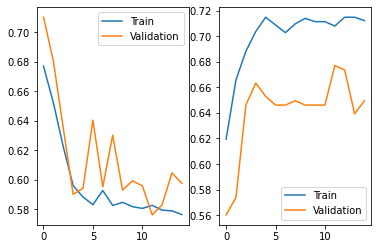

In [14]:
#Freshman 1st Semester
grade_modeling(data,4,15)

### After Sophomore Year

Epoch 1/15
37/37 [==============================] - 0s 12ms/step - loss: 0.5852 - accuracy: 0.7148 - val_loss: 0.6295 - val_accuracy: 0.7732
Epoch 2/15
37/37 [==============================] - 0s 5ms/step - loss: 0.5079 - accuracy: 0.8428 - val_loss: 0.6318 - val_accuracy: 0.7526
Epoch 3/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4760 - accuracy: 0.8505 - val_loss: 0.5230 - val_accuracy: 0.7766
Epoch 4/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4071 - accuracy: 0.8574 - val_loss: 0.4982 - val_accuracy: 0.7869
Epoch 5/15
37/37 [==============================] - 0s 6ms/step - loss: 0.3802 - accuracy: 0.8625 - val_loss: 0.4386 - val_accuracy: 0.8007
Epoch 6/15
37/37 [==============================] - 0s 5ms/step - loss: 0.3540 - accuracy: 0.8686 - val_loss: 0.3899 - val_accuracy: 0.8247
Epoch 7/15
37/37 [==============================] - 0s 5ms/step - loss: 0.3361 - accuracy: 0.8660 - val_loss: 0.4211 - val_accuracy: 0.8007
Epoch 8/15
37/37 [=

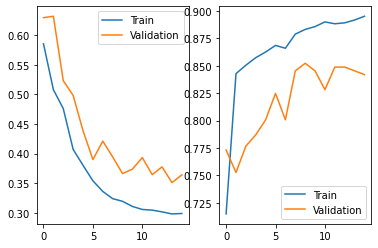

In [15]:
#Sophomore
grade_modeling(data,16,15)